<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2

from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision
from tqdm.notebook import trange, tqdm

import random
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.manifold import TSNE

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.manual_seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#!gdown 1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x
#!unzip -q 'archive.zip' -d ./data
dataset_path = '/kaggle/input/gan-hw-reduced-dataset/dataset (1).pt'

In [5]:
image_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transform_resize = transforms.Compose([
    transforms.Resize(size=(image_size, image_size)),
    transforms.ToTensor(),
    tt.Normalize(*stats)
])

class CustomDataSet(Dataset):
    def __init__(self, paths, transform):
        self.transform = transform
        self.paths = paths
        self.init_transform = transform_resize
        self.data = []
        self.load_in_memory()

    def load_in_memory(self):
        for path in tqdm(self.paths):
            image = Image.open(path).convert("RGB")
            self.data.append(self.init_transform(image))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [6]:
def get_dataset(folder: str = '/content/data', stats = stats, loaded=False) -> CustomDataSet:
    if loaded:
        return torch.load(dataset_path)
    transform = {
      'train': transforms.Compose([
          transforms.RandomRotation(degrees=10),
          transforms.RandomHorizontalFlip()
      ]),
      'val_test': transforms.Compose([]),
    }

    assert os.path.exists(folder)

    photo_paths = []
    for dirpath, dirnames, filenames in os.walk(folder):
        for fname in filenames:
            if fname.endswith(".png"):
                photo_paths.append(os.path.join(dirpath, fname))

    return CustomDataSet(photo_paths, transform=transform['train'])

In [7]:
def get_dataloader(batch_size, folder: str = './data', stats = stats, loaded=False) -> DataLoader:
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    dataset = get_dataset(folder, stats, loaded)
    return DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
batch_size = 128

#build dataloader and transfer it to device
data = get_dataloader(batch_size, loaded=True)

In [9]:
next(enumerate(data))[1].shape

torch.Size([128, 3, 128, 128])

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    show_images(dl, nmax)

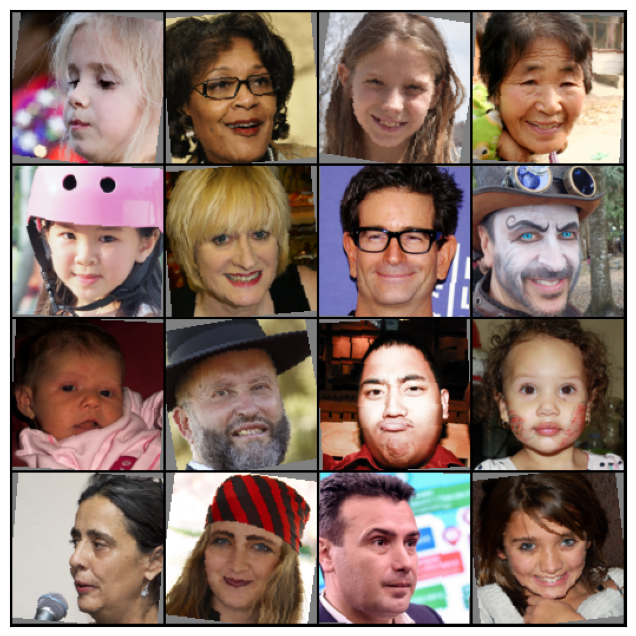

In [11]:
show_batch(next(enumerate(data))[1])

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
train_dl = DeviceDataLoader(data, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.Flatten(),
    nn.Linear(1024 * 4 * 4, 1024 * 4 * 4),
    nn.ReLU(True),
    nn.Unflatten(1, (1024, 4, 4)),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
    # Тест
#     nn.Flatten(),
#     nn.Linear(128 * 128 * 3, 128 * 128 * 3),
#     nn.ReLU(True),
#     nn.Unflatten(1, (3, 128, 128)),

    # out: 3 x 128 x 128
)

In [17]:
generator = to_device(generator, device)

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = generator(xb)
fake_images.shape

torch.Size([128, 3, 128, 128])

In [19]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [22]:

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [23]:
def fit(model, criterion, epochs, lr_disc, lr_gen, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr_disc / .75, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr_gen / .75, betas=(0.5, 0.999))  # x на 0 epoch
    }
    scheduler = {
        # Тест: discriminator быстрее замедляет обучение
        "discriminator": torch.optim.lr_scheduler.ExponentialLR(
            optimizer['discriminator'], gamma=.75
        ),
        "generator": torch.optim.lr_scheduler.ExponentialLR(
            optimizer['generator'], gamma=.75
        ),
    }
    for epoch in trange(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
#             noise = to_device(
#                 torch.normal(0, .1, size=(real_images.size(0), 1)), device
#             )
#             noise = to_device(torch.Tensor(
#                 np.random.uniform(low=-.03, high=.03, size=real_images.size(0))
#             ), device).reshape(-1, 1)

#             real_preds = torch.clip(real_preds + noise, 0.02, .98)

            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], lr: {:.8f} loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, scheduler['generator'].get_last_lr()[-1],
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        if epoch % 10 == 0:
            scheduler['discriminator'].step()
            scheduler['generator'].step()

        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [24]:
epochs = 300
history = fit(model, criterion, epochs, 0.001, 0.001)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/300], lr: 0.00133333 loss_g: 7.4616, loss_d: 1.9155, real_score: 0.8128, fake_score: 0.2680


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/300], lr: 0.00100000 loss_g: 7.5825, loss_d: 0.2085, real_score: 0.9692, fake_score: 0.0722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/300], lr: 0.00100000 loss_g: 6.3894, loss_d: 0.9951, real_score: 0.8733, fake_score: 0.1799


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/300], lr: 0.00100000 loss_g: 7.6187, loss_d: 0.0968, real_score: 0.9813, fake_score: 0.0462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/300], lr: 0.00100000 loss_g: 6.9266, loss_d: 1.1137, real_score: 0.8779, fake_score: 0.1334


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/300], lr: 0.00100000 loss_g: 7.9764, loss_d: 1.8853, real_score: 0.7670, fake_score: 0.2663


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/300], lr: 0.00100000 loss_g: 7.4947, loss_d: 0.7706, real_score: 0.9055, fake_score: 0.1144


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/300], lr: 0.00100000 loss_g: 5.3559, loss_d: 3.0650, real_score: 0.6324, fake_score: 0.3529


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/300], lr: 0.00100000 loss_g: 7.8950, loss_d: 0.9350, real_score: 0.8297, fake_score: 0.1973


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/300], lr: 0.00100000 loss_g: 8.0255, loss_d: 1.4518, real_score: 0.8494, fake_score: 0.1799


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/300], lr: 0.00100000 loss_g: 5.3518, loss_d: 0.5905, real_score: 0.8736, fake_score: 0.1684


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/300], lr: 0.00075000 loss_g: 6.9018, loss_d: 0.1113, real_score: 0.9702, fake_score: 0.0607


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/300], lr: 0.00075000 loss_g: 7.2859, loss_d: 0.0978, real_score: 0.9753, fake_score: 0.0370


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/300], lr: 0.00075000 loss_g: 8.3908, loss_d: 0.4159, real_score: 0.9355, fake_score: 0.0891


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/300], lr: 0.00075000 loss_g: 10.1203, loss_d: 1.2274, real_score: 0.8398, fake_score: 0.1790


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/300], lr: 0.00075000 loss_g: 6.2951, loss_d: 0.0705, real_score: 0.9771, fake_score: 0.0380


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/300], lr: 0.00075000 loss_g: 11.2373, loss_d: 1.4553, real_score: 0.8277, fake_score: 0.1950


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/300], lr: 0.00075000 loss_g: 7.5145, loss_d: 1.5167, real_score: 0.7798, fake_score: 0.1794


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/300], lr: 0.00075000 loss_g: 6.0372, loss_d: 0.8089, real_score: 0.8186, fake_score: 0.2079


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/300], lr: 0.00075000 loss_g: 4.5379, loss_d: 1.5871, real_score: 0.6779, fake_score: 0.2983


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/300], lr: 0.00075000 loss_g: 3.4626, loss_d: 1.6237, real_score: 0.6519, fake_score: 0.3308


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/300], lr: 0.00056250 loss_g: 4.1532, loss_d: 0.9976, real_score: 0.7089, fake_score: 0.2796


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/300], lr: 0.00056250 loss_g: 3.8977, loss_d: 1.2439, real_score: 0.6782, fake_score: 0.3113


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/300], lr: 0.00056250 loss_g: 3.5251, loss_d: 0.7569, real_score: 0.7639, fake_score: 0.2409


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/300], lr: 0.00056250 loss_g: 3.8628, loss_d: 0.9061, real_score: 0.7308, fake_score: 0.2566


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/300], lr: 0.00056250 loss_g: 3.2105, loss_d: 0.9486, real_score: 0.7511, fake_score: 0.2606


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/300], lr: 0.00056250 loss_g: 3.1692, loss_d: 0.7595, real_score: 0.7558, fake_score: 0.2522


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/300], lr: 0.00056250 loss_g: 3.6168, loss_d: 1.1474, real_score: 0.6954, fake_score: 0.2839


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/300], lr: 0.00056250 loss_g: 3.8935, loss_d: 1.0412, real_score: 0.7411, fake_score: 0.2611


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/300], lr: 0.00056250 loss_g: 3.4123, loss_d: 0.6886, real_score: 0.7829, fake_score: 0.2240


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/300], lr: 0.00056250 loss_g: 3.3709, loss_d: 0.8101, real_score: 0.7393, fake_score: 0.2475


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/300], lr: 0.00042188 loss_g: 3.7207, loss_d: 0.7892, real_score: 0.7634, fake_score: 0.2478


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/300], lr: 0.00042188 loss_g: 4.1313, loss_d: 0.6152, real_score: 0.7969, fake_score: 0.2113


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/300], lr: 0.00042188 loss_g: 4.3233, loss_d: 0.6533, real_score: 0.7919, fake_score: 0.2068


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/300], lr: 0.00042188 loss_g: 4.2749, loss_d: 0.5576, real_score: 0.8306, fake_score: 0.1771


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/300], lr: 0.00042188 loss_g: 5.0462, loss_d: 1.0536, real_score: 0.7358, fake_score: 0.2636


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/300], lr: 0.00042188 loss_g: 5.6452, loss_d: 0.6231, real_score: 0.8227, fake_score: 0.1921


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/300], lr: 0.00042188 loss_g: 4.5185, loss_d: 1.0732, real_score: 0.7206, fake_score: 0.2606


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/300], lr: 0.00042188 loss_g: 3.8656, loss_d: 0.7465, real_score: 0.7627, fake_score: 0.2272


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/300], lr: 0.00042188 loss_g: 4.6327, loss_d: 1.0093, real_score: 0.7373, fake_score: 0.2624


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/300], lr: 0.00042188 loss_g: 3.5550, loss_d: 0.7907, real_score: 0.7457, fake_score: 0.2374


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/300], lr: 0.00031641 loss_g: 4.2668, loss_d: 0.6723, real_score: 0.7874, fake_score: 0.2065


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43/300], lr: 0.00031641 loss_g: 5.0100, loss_d: 0.8631, real_score: 0.7932, fake_score: 0.2320


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44/300], lr: 0.00031641 loss_g: 4.0089, loss_d: 0.6204, real_score: 0.7970, fake_score: 0.2121


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45/300], lr: 0.00031641 loss_g: 4.6102, loss_d: 0.7097, real_score: 0.7756, fake_score: 0.1963


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46/300], lr: 0.00031641 loss_g: 4.5604, loss_d: 0.8946, real_score: 0.7628, fake_score: 0.2471


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47/300], lr: 0.00031641 loss_g: 4.8189, loss_d: 0.4942, real_score: 0.8387, fake_score: 0.1640


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48/300], lr: 0.00031641 loss_g: 5.4218, loss_d: 0.4680, real_score: 0.8512, fake_score: 0.1549


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [49/300], lr: 0.00031641 loss_g: 4.8574, loss_d: 0.7448, real_score: 0.7777, fake_score: 0.2163


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [50/300], lr: 0.00031641 loss_g: 5.4613, loss_d: 0.5124, real_score: 0.8524, fake_score: 0.1930


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [51/300], lr: 0.00031641 loss_g: 5.1415, loss_d: 0.8467, real_score: 0.7666, fake_score: 0.2039


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [52/300], lr: 0.00023730 loss_g: 5.4455, loss_d: 0.9160, real_score: 0.7258, fake_score: 0.2609


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [53/300], lr: 0.00023730 loss_g: 5.2908, loss_d: 0.6793, real_score: 0.7976, fake_score: 0.1948


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [54/300], lr: 0.00023730 loss_g: 4.8121, loss_d: 0.6214, real_score: 0.8149, fake_score: 0.1939


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [55/300], lr: 0.00023730 loss_g: 4.1652, loss_d: 0.6922, real_score: 0.7814, fake_score: 0.1846


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [56/300], lr: 0.00023730 loss_g: 4.5467, loss_d: 0.4658, real_score: 0.8326, fake_score: 0.1635


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [57/300], lr: 0.00023730 loss_g: 4.1477, loss_d: 0.4669, real_score: 0.8378, fake_score: 0.1627


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [58/300], lr: 0.00023730 loss_g: 4.7490, loss_d: 0.5653, real_score: 0.8257, fake_score: 0.1797


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [59/300], lr: 0.00023730 loss_g: 5.1951, loss_d: 0.7688, real_score: 0.7792, fake_score: 0.2113


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [60/300], lr: 0.00023730 loss_g: 5.0909, loss_d: 0.4908, real_score: 0.8419, fake_score: 0.1768


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [61/300], lr: 0.00023730 loss_g: 5.2540, loss_d: 0.7719, real_score: 0.7865, fake_score: 0.2030


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [62/300], lr: 0.00017798 loss_g: 3.6116, loss_d: 0.5835, real_score: 0.7927, fake_score: 0.1912


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [63/300], lr: 0.00017798 loss_g: 4.2736, loss_d: 0.4499, real_score: 0.8411, fake_score: 0.1655


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [64/300], lr: 0.00017798 loss_g: 5.0319, loss_d: 0.4172, real_score: 0.8589, fake_score: 0.1370


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [65/300], lr: 0.00017798 loss_g: 4.7989, loss_d: 0.4339, real_score: 0.8595, fake_score: 0.1481


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [66/300], lr: 0.00017798 loss_g: 4.0953, loss_d: 0.3704, real_score: 0.8586, fake_score: 0.1285


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [67/300], lr: 0.00017798 loss_g: 4.8509, loss_d: 0.3496, real_score: 0.8702, fake_score: 0.1269


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [68/300], lr: 0.00017798 loss_g: 6.7350, loss_d: 0.3633, real_score: 0.8890, fake_score: 0.1339


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [69/300], lr: 0.00017798 loss_g: 5.3138, loss_d: 0.4356, real_score: 0.8583, fake_score: 0.1273


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [70/300], lr: 0.00017798 loss_g: 5.2027, loss_d: 0.5020, real_score: 0.8390, fake_score: 0.1607


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [71/300], lr: 0.00017798 loss_g: 4.0669, loss_d: 0.4354, real_score: 0.8479, fake_score: 0.1629


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [72/300], lr: 0.00013348 loss_g: 4.0350, loss_d: 0.5051, real_score: 0.8187, fake_score: 0.1726


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [73/300], lr: 0.00013348 loss_g: 4.3570, loss_d: 0.4528, real_score: 0.8326, fake_score: 0.1475


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [74/300], lr: 0.00013348 loss_g: 4.0941, loss_d: 0.4207, real_score: 0.8491, fake_score: 0.1523


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [75/300], lr: 0.00013348 loss_g: 4.2325, loss_d: 0.3408, real_score: 0.8762, fake_score: 0.1201


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [76/300], lr: 0.00013348 loss_g: 4.0753, loss_d: 0.4718, real_score: 0.8312, fake_score: 0.1624


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [77/300], lr: 0.00013348 loss_g: 4.8475, loss_d: 0.5670, real_score: 0.8234, fake_score: 0.1657


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [78/300], lr: 0.00013348 loss_g: 3.9403, loss_d: 0.4414, real_score: 0.8491, fake_score: 0.1565


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [79/300], lr: 0.00013348 loss_g: 4.3774, loss_d: 0.3319, real_score: 0.8695, fake_score: 0.1232


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [80/300], lr: 0.00013348 loss_g: 5.5558, loss_d: 0.5093, real_score: 0.8405, fake_score: 0.1576


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [81/300], lr: 0.00013348 loss_g: 4.8266, loss_d: 0.5127, real_score: 0.8479, fake_score: 0.1471


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [82/300], lr: 0.00010011 loss_g: 3.8539, loss_d: 0.3504, real_score: 0.8665, fake_score: 0.1274


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [83/300], lr: 0.00010011 loss_g: 4.4677, loss_d: 0.3606, real_score: 0.8619, fake_score: 0.1268


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [84/300], lr: 0.00010011 loss_g: 4.0658, loss_d: 0.3400, real_score: 0.8769, fake_score: 0.1330


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [85/300], lr: 0.00010011 loss_g: 3.9494, loss_d: 0.3572, real_score: 0.8615, fake_score: 0.1319


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [86/300], lr: 0.00010011 loss_g: 4.6761, loss_d: 0.4379, real_score: 0.8514, fake_score: 0.1436


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [87/300], lr: 0.00010011 loss_g: 4.5186, loss_d: 0.3887, real_score: 0.8699, fake_score: 0.1312


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [88/300], lr: 0.00010011 loss_g: 4.5103, loss_d: 0.2773, real_score: 0.8951, fake_score: 0.1063


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [89/300], lr: 0.00010011 loss_g: 4.2758, loss_d: 0.2625, real_score: 0.8972, fake_score: 0.1010


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [90/300], lr: 0.00010011 loss_g: 4.2635, loss_d: 0.3299, real_score: 0.8811, fake_score: 0.1252


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [91/300], lr: 0.00010011 loss_g: 5.0558, loss_d: 0.2986, real_score: 0.8868, fake_score: 0.1021


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [92/300], lr: 0.00007508 loss_g: 4.1144, loss_d: 0.3432, real_score: 0.8784, fake_score: 0.1250


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [93/300], lr: 0.00007508 loss_g: 4.1280, loss_d: 0.3236, real_score: 0.8784, fake_score: 0.1161


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [94/300], lr: 0.00007508 loss_g: 4.7010, loss_d: 0.3227, real_score: 0.8903, fake_score: 0.1225


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [95/300], lr: 0.00007508 loss_g: 3.8399, loss_d: 0.3817, real_score: 0.8548, fake_score: 0.1287


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [96/300], lr: 0.00007508 loss_g: 4.4694, loss_d: 0.3203, real_score: 0.8787, fake_score: 0.1075


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [97/300], lr: 0.00007508 loss_g: 4.4044, loss_d: 0.3122, real_score: 0.8875, fake_score: 0.1130


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [98/300], lr: 0.00007508 loss_g: 3.9264, loss_d: 0.2710, real_score: 0.8990, fake_score: 0.1065


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [99/300], lr: 0.00007508 loss_g: 4.5765, loss_d: 0.3660, real_score: 0.8651, fake_score: 0.1247


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [100/300], lr: 0.00007508 loss_g: 5.1141, loss_d: 0.3193, real_score: 0.8945, fake_score: 0.1185


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [101/300], lr: 0.00007508 loss_g: 4.6962, loss_d: 0.3467, real_score: 0.8802, fake_score: 0.1221


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [102/300], lr: 0.00005631 loss_g: 3.5571, loss_d: 0.2696, real_score: 0.8915, fake_score: 0.1008


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [103/300], lr: 0.00005631 loss_g: 4.1917, loss_d: 0.3197, real_score: 0.8781, fake_score: 0.1128


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [104/300], lr: 0.00005631 loss_g: 3.9208, loss_d: 0.2641, real_score: 0.8958, fake_score: 0.1042


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [105/300], lr: 0.00005631 loss_g: 3.9439, loss_d: 0.2032, real_score: 0.9208, fake_score: 0.0845


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [106/300], lr: 0.00005631 loss_g: 3.8571, loss_d: 0.2275, real_score: 0.9096, fake_score: 0.0863


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [107/300], lr: 0.00005631 loss_g: 3.8907, loss_d: 0.2784, real_score: 0.8922, fake_score: 0.1022


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [108/300], lr: 0.00005631 loss_g: 4.0606, loss_d: 0.2804, real_score: 0.8892, fake_score: 0.0940


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [109/300], lr: 0.00005631 loss_g: 4.8754, loss_d: 0.4226, real_score: 0.8629, fake_score: 0.1351


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [110/300], lr: 0.00005631 loss_g: 4.3407, loss_d: 0.2356, real_score: 0.9121, fake_score: 0.0998


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [111/300], lr: 0.00005631 loss_g: 4.2883, loss_d: 0.2896, real_score: 0.8889, fake_score: 0.1041


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [112/300], lr: 0.00004224 loss_g: 3.5994, loss_d: 0.2113, real_score: 0.9131, fake_score: 0.0769


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [113/300], lr: 0.00004224 loss_g: 3.6818, loss_d: 0.2577, real_score: 0.8988, fake_score: 0.0946


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [114/300], lr: 0.00004224 loss_g: 3.9785, loss_d: 0.2086, real_score: 0.9126, fake_score: 0.0799


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [115/300], lr: 0.00004224 loss_g: 4.0163, loss_d: 0.2216, real_score: 0.9085, fake_score: 0.0822


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [116/300], lr: 0.00004224 loss_g: 4.0451, loss_d: 0.1921, real_score: 0.9180, fake_score: 0.0721


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [117/300], lr: 0.00004224 loss_g: 4.3267, loss_d: 0.1399, real_score: 0.9467, fake_score: 0.0621


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [118/300], lr: 0.00004224 loss_g: 4.3071, loss_d: 0.1840, real_score: 0.9351, fake_score: 0.0835


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [119/300], lr: 0.00004224 loss_g: 4.2152, loss_d: 0.1444, real_score: 0.9375, fake_score: 0.0554


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [120/300], lr: 0.00004224 loss_g: 4.4492, loss_d: 0.1425, real_score: 0.9365, fake_score: 0.0531


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [121/300], lr: 0.00004224 loss_g: 4.7521, loss_d: 0.1812, real_score: 0.9252, fake_score: 0.0619


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [122/300], lr: 0.00003168 loss_g: 4.3217, loss_d: 0.1253, real_score: 0.9493, fake_score: 0.0476


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [123/300], lr: 0.00003168 loss_g: 4.0485, loss_d: 0.1866, real_score: 0.9341, fake_score: 0.0788


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [124/300], lr: 0.00003168 loss_g: 4.6177, loss_d: 0.1837, real_score: 0.9332, fake_score: 0.0709


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [125/300], lr: 0.00003168 loss_g: 4.0681, loss_d: 0.2036, real_score: 0.9175, fake_score: 0.0742


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [126/300], lr: 0.00003168 loss_g: 3.8182, loss_d: 0.1649, real_score: 0.9305, fake_score: 0.0580


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [127/300], lr: 0.00003168 loss_g: 3.8153, loss_d: 0.2036, real_score: 0.9203, fake_score: 0.0732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [128/300], lr: 0.00003168 loss_g: 3.7020, loss_d: 0.1872, real_score: 0.9262, fake_score: 0.0771


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [129/300], lr: 0.00003168 loss_g: 3.6619, loss_d: 0.1267, real_score: 0.9510, fake_score: 0.0545


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [130/300], lr: 0.00003168 loss_g: 3.8636, loss_d: 0.1587, real_score: 0.9408, fake_score: 0.0681


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [131/300], lr: 0.00003168 loss_g: 3.7601, loss_d: 0.1524, real_score: 0.9388, fake_score: 0.0585


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [132/300], lr: 0.00002376 loss_g: 3.5280, loss_d: 0.1726, real_score: 0.9307, fake_score: 0.0627


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [133/300], lr: 0.00002376 loss_g: 3.5801, loss_d: 0.1731, real_score: 0.9305, fake_score: 0.0655


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [134/300], lr: 0.00002376 loss_g: 3.6411, loss_d: 0.1650, real_score: 0.9299, fake_score: 0.0629


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [135/300], lr: 0.00002376 loss_g: 4.0547, loss_d: 0.1185, real_score: 0.9521, fake_score: 0.0506


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [136/300], lr: 0.00002376 loss_g: 4.1287, loss_d: 0.1243, real_score: 0.9499, fake_score: 0.0552


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [137/300], lr: 0.00002376 loss_g: 4.1625, loss_d: 0.1257, real_score: 0.9439, fake_score: 0.0478


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [138/300], lr: 0.00002376 loss_g: 3.8245, loss_d: 0.1812, real_score: 0.9301, fake_score: 0.0671


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [139/300], lr: 0.00002376 loss_g: 3.8746, loss_d: 0.1293, real_score: 0.9463, fake_score: 0.0521


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [140/300], lr: 0.00002376 loss_g: 4.0247, loss_d: 0.1490, real_score: 0.9394, fake_score: 0.0583


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [141/300], lr: 0.00002376 loss_g: 3.7269, loss_d: 0.1504, real_score: 0.9342, fake_score: 0.0568


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [142/300], lr: 0.00001782 loss_g: 3.5872, loss_d: 0.1519, real_score: 0.9331, fake_score: 0.0558


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [143/300], lr: 0.00001782 loss_g: 3.8064, loss_d: 0.1411, real_score: 0.9411, fake_score: 0.0549


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [144/300], lr: 0.00001782 loss_g: 3.8506, loss_d: 0.1242, real_score: 0.9475, fake_score: 0.0479


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [145/300], lr: 0.00001782 loss_g: 3.8388, loss_d: 0.1023, real_score: 0.9579, fake_score: 0.0441


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [146/300], lr: 0.00001782 loss_g: 3.9237, loss_d: 0.1387, real_score: 0.9429, fake_score: 0.0569


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [147/300], lr: 0.00001782 loss_g: 3.9506, loss_d: 0.1531, real_score: 0.9310, fake_score: 0.0560


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [148/300], lr: 0.00001782 loss_g: 4.0649, loss_d: 0.1255, real_score: 0.9469, fake_score: 0.0477


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [149/300], lr: 0.00001782 loss_g: 3.9656, loss_d: 0.1271, real_score: 0.9509, fake_score: 0.0483


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [150/300], lr: 0.00001782 loss_g: 3.9768, loss_d: 0.1352, real_score: 0.9492, fake_score: 0.0575


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [151/300], lr: 0.00001782 loss_g: 3.8861, loss_d: 0.1251, real_score: 0.9499, fake_score: 0.0520


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [152/300], lr: 0.00001336 loss_g: 3.6603, loss_d: 0.1143, real_score: 0.9555, fake_score: 0.0524


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [153/300], lr: 0.00001336 loss_g: 3.7570, loss_d: 0.1261, real_score: 0.9481, fake_score: 0.0533


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [154/300], lr: 0.00001336 loss_g: 4.0127, loss_d: 0.1060, real_score: 0.9539, fake_score: 0.0441


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [155/300], lr: 0.00001336 loss_g: 4.0722, loss_d: 0.1068, real_score: 0.9546, fake_score: 0.0441


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [156/300], lr: 0.00001336 loss_g: 3.9732, loss_d: 0.1122, real_score: 0.9520, fake_score: 0.0446


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [157/300], lr: 0.00001336 loss_g: 3.7489, loss_d: 0.1414, real_score: 0.9403, fake_score: 0.0507


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [158/300], lr: 0.00001336 loss_g: 3.4664, loss_d: 0.1721, real_score: 0.9304, fake_score: 0.0646


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [159/300], lr: 0.00001336 loss_g: 3.4669, loss_d: 0.1905, real_score: 0.9209, fake_score: 0.0723


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [160/300], lr: 0.00001336 loss_g: 3.6785, loss_d: 0.1214, real_score: 0.9487, fake_score: 0.0510


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [161/300], lr: 0.00001336 loss_g: 3.6718, loss_d: 0.1438, real_score: 0.9378, fake_score: 0.0565


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [162/300], lr: 0.00001002 loss_g: 3.5940, loss_d: 0.1167, real_score: 0.9482, fake_score: 0.0486


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [163/300], lr: 0.00001002 loss_g: 3.3768, loss_d: 0.1524, real_score: 0.9353, fake_score: 0.0598


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [164/300], lr: 0.00001002 loss_g: 3.6200, loss_d: 0.1515, real_score: 0.9350, fake_score: 0.0589


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [165/300], lr: 0.00001002 loss_g: 3.8327, loss_d: 0.1289, real_score: 0.9422, fake_score: 0.0507


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [166/300], lr: 0.00001002 loss_g: 3.7864, loss_d: 0.1268, real_score: 0.9457, fake_score: 0.0502


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [167/300], lr: 0.00001002 loss_g: 3.5650, loss_d: 0.1145, real_score: 0.9517, fake_score: 0.0460


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [168/300], lr: 0.00001002 loss_g: 3.4842, loss_d: 0.1255, real_score: 0.9480, fake_score: 0.0528


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [169/300], lr: 0.00001002 loss_g: 3.5467, loss_d: 0.1096, real_score: 0.9527, fake_score: 0.0470


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [170/300], lr: 0.00001002 loss_g: 3.6777, loss_d: 0.0959, real_score: 0.9595, fake_score: 0.0412


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [171/300], lr: 0.00001002 loss_g: 3.6244, loss_d: 0.1120, real_score: 0.9536, fake_score: 0.0466


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [172/300], lr: 0.00000752 loss_g: 3.4527, loss_d: 0.1264, real_score: 0.9437, fake_score: 0.0472


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [173/300], lr: 0.00000752 loss_g: 3.5745, loss_d: 0.1142, real_score: 0.9517, fake_score: 0.0462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [174/300], lr: 0.00000752 loss_g: 3.5874, loss_d: 0.1186, real_score: 0.9478, fake_score: 0.0428


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [175/300], lr: 0.00000752 loss_g: 3.6455, loss_d: 0.1126, real_score: 0.9496, fake_score: 0.0422


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [176/300], lr: 0.00000752 loss_g: 3.7050, loss_d: 0.1103, real_score: 0.9503, fake_score: 0.0399


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [177/300], lr: 0.00000752 loss_g: 3.5543, loss_d: 0.1223, real_score: 0.9463, fake_score: 0.0424


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [178/300], lr: 0.00000752 loss_g: 3.5825, loss_d: 0.1153, real_score: 0.9502, fake_score: 0.0426


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [179/300], lr: 0.00000752 loss_g: 3.5529, loss_d: 0.1269, real_score: 0.9465, fake_score: 0.0496


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [180/300], lr: 0.00000752 loss_g: 3.5359, loss_d: 0.1411, real_score: 0.9413, fake_score: 0.0538


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [181/300], lr: 0.00000752 loss_g: 3.6757, loss_d: 0.0934, real_score: 0.9601, fake_score: 0.0411


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [182/300], lr: 0.00000564 loss_g: 3.9160, loss_d: 0.0659, real_score: 0.9718, fake_score: 0.0298


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [183/300], lr: 0.00000564 loss_g: 3.9945, loss_d: 0.0574, real_score: 0.9760, fake_score: 0.0265


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [184/300], lr: 0.00000564 loss_g: 4.1774, loss_d: 0.0482, real_score: 0.9793, fake_score: 0.0227


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [185/300], lr: 0.00000564 loss_g: 4.1962, loss_d: 0.0469, real_score: 0.9798, fake_score: 0.0223


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [186/300], lr: 0.00000564 loss_g: 4.1682, loss_d: 0.0442, real_score: 0.9827, fake_score: 0.0227


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [187/300], lr: 0.00000564 loss_g: 4.0953, loss_d: 0.0590, real_score: 0.9763, fake_score: 0.0287


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [188/300], lr: 0.00000564 loss_g: 3.9171, loss_d: 0.0828, real_score: 0.9662, fake_score: 0.0355


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [189/300], lr: 0.00000564 loss_g: 3.9554, loss_d: 0.0887, real_score: 0.9653, fake_score: 0.0376


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [190/300], lr: 0.00000564 loss_g: 3.9530, loss_d: 0.0877, real_score: 0.9635, fake_score: 0.0365


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [191/300], lr: 0.00000564 loss_g: 3.9482, loss_d: 0.0888, real_score: 0.9608, fake_score: 0.0359


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [192/300], lr: 0.00000423 loss_g: 3.8143, loss_d: 0.0971, real_score: 0.9591, fake_score: 0.0394


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [193/300], lr: 0.00000423 loss_g: 3.7457, loss_d: 0.0926, real_score: 0.9622, fake_score: 0.0395


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [194/300], lr: 0.00000423 loss_g: 3.8389, loss_d: 0.0897, real_score: 0.9618, fake_score: 0.0351


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [195/300], lr: 0.00000423 loss_g: 3.7445, loss_d: 0.0839, real_score: 0.9645, fake_score: 0.0334


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [196/300], lr: 0.00000423 loss_g: 3.8519, loss_d: 0.0837, real_score: 0.9661, fake_score: 0.0358


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [197/300], lr: 0.00000423 loss_g: 3.7132, loss_d: 0.0793, real_score: 0.9664, fake_score: 0.0332


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [198/300], lr: 0.00000423 loss_g: 3.7054, loss_d: 0.0893, real_score: 0.9642, fake_score: 0.0386


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [199/300], lr: 0.00000423 loss_g: 3.7865, loss_d: 0.0908, real_score: 0.9610, fake_score: 0.0362


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [200/300], lr: 0.00000423 loss_g: 3.4927, loss_d: 0.1102, real_score: 0.9541, fake_score: 0.0408


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [201/300], lr: 0.00000423 loss_g: 3.5191, loss_d: 0.1146, real_score: 0.9521, fake_score: 0.0458


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [202/300], lr: 0.00000317 loss_g: 3.5429, loss_d: 0.1102, real_score: 0.9530, fake_score: 0.0432


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [203/300], lr: 0.00000317 loss_g: 3.3833, loss_d: 0.1259, real_score: 0.9476, fake_score: 0.0482


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [204/300], lr: 0.00000317 loss_g: 3.4353, loss_d: 0.1111, real_score: 0.9539, fake_score: 0.0463


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [205/300], lr: 0.00000317 loss_g: 3.4868, loss_d: 0.1188, real_score: 0.9514, fake_score: 0.0479


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [206/300], lr: 0.00000317 loss_g: 3.5144, loss_d: 0.1061, real_score: 0.9533, fake_score: 0.0432


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [207/300], lr: 0.00000317 loss_g: 3.5560, loss_d: 0.0987, real_score: 0.9595, fake_score: 0.0434


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [208/300], lr: 0.00000317 loss_g: 3.7619, loss_d: 0.0892, real_score: 0.9633, fake_score: 0.0387


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [209/300], lr: 0.00000317 loss_g: 3.6929, loss_d: 0.0821, real_score: 0.9641, fake_score: 0.0348


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [210/300], lr: 0.00000317 loss_g: 3.7401, loss_d: 0.0846, real_score: 0.9645, fake_score: 0.0368


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [211/300], lr: 0.00000317 loss_g: 3.8157, loss_d: 0.0807, real_score: 0.9647, fake_score: 0.0334


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [212/300], lr: 0.00000238 loss_g: 3.7980, loss_d: 0.0701, real_score: 0.9701, fake_score: 0.0326


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [213/300], lr: 0.00000238 loss_g: 3.8124, loss_d: 0.0726, real_score: 0.9687, fake_score: 0.0325


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [214/300], lr: 0.00000238 loss_g: 3.8824, loss_d: 0.0686, real_score: 0.9700, fake_score: 0.0314


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [215/300], lr: 0.00000238 loss_g: 3.7885, loss_d: 0.0712, real_score: 0.9679, fake_score: 0.0303


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [216/300], lr: 0.00000238 loss_g: 3.7024, loss_d: 0.0798, real_score: 0.9637, fake_score: 0.0337


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [217/300], lr: 0.00000238 loss_g: 3.6244, loss_d: 0.0788, real_score: 0.9651, fake_score: 0.0343


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [218/300], lr: 0.00000238 loss_g: 3.6697, loss_d: 0.0798, real_score: 0.9649, fake_score: 0.0345


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [219/300], lr: 0.00000238 loss_g: 3.6807, loss_d: 0.0795, real_score: 0.9657, fake_score: 0.0346


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [220/300], lr: 0.00000238 loss_g: 3.5689, loss_d: 0.0898, real_score: 0.9599, fake_score: 0.0361


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [221/300], lr: 0.00000238 loss_g: 3.5467, loss_d: 0.0897, real_score: 0.9625, fake_score: 0.0400


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [222/300], lr: 0.00000178 loss_g: 3.4389, loss_d: 0.1046, real_score: 0.9550, fake_score: 0.0418


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [223/300], lr: 0.00000178 loss_g: 3.4650, loss_d: 0.1003, real_score: 0.9592, fake_score: 0.0437


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [224/300], lr: 0.00000178 loss_g: 3.4590, loss_d: 0.0990, real_score: 0.9557, fake_score: 0.0404


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [225/300], lr: 0.00000178 loss_g: 3.4471, loss_d: 0.0961, real_score: 0.9598, fake_score: 0.0422


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [226/300], lr: 0.00000178 loss_g: 3.4668, loss_d: 0.1043, real_score: 0.9559, fake_score: 0.0441


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [227/300], lr: 0.00000178 loss_g: 3.5109, loss_d: 0.0933, real_score: 0.9600, fake_score: 0.0396


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [228/300], lr: 0.00000178 loss_g: 3.4913, loss_d: 0.0948, real_score: 0.9585, fake_score: 0.0403


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [229/300], lr: 0.00000178 loss_g: 3.4398, loss_d: 0.0988, real_score: 0.9575, fake_score: 0.0416


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [230/300], lr: 0.00000178 loss_g: 3.4594, loss_d: 0.0954, real_score: 0.9598, fake_score: 0.0407


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [231/300], lr: 0.00000178 loss_g: 3.4677, loss_d: 0.0932, real_score: 0.9593, fake_score: 0.0401


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [232/300], lr: 0.00000134 loss_g: 3.3843, loss_d: 0.0947, real_score: 0.9592, fake_score: 0.0413


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [233/300], lr: 0.00000134 loss_g: 3.3529, loss_d: 0.1013, real_score: 0.9563, fake_score: 0.0412


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [234/300], lr: 0.00000134 loss_g: 3.4415, loss_d: 0.0963, real_score: 0.9599, fake_score: 0.0418


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [235/300], lr: 0.00000134 loss_g: 3.4588, loss_d: 0.0920, real_score: 0.9607, fake_score: 0.0403


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [236/300], lr: 0.00000134 loss_g: 3.5511, loss_d: 0.0969, real_score: 0.9582, fake_score: 0.0421


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [237/300], lr: 0.00000134 loss_g: 3.4132, loss_d: 0.1093, real_score: 0.9537, fake_score: 0.0458


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [238/300], lr: 0.00000134 loss_g: 3.3781, loss_d: 0.0994, real_score: 0.9570, fake_score: 0.0432


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [239/300], lr: 0.00000134 loss_g: 3.5017, loss_d: 0.1116, real_score: 0.9517, fake_score: 0.0448


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [240/300], lr: 0.00000134 loss_g: 3.4493, loss_d: 0.1064, real_score: 0.9547, fake_score: 0.0434


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [241/300], lr: 0.00000134 loss_g: 3.4483, loss_d: 0.0994, real_score: 0.9556, fake_score: 0.0425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [242/300], lr: 0.00000100 loss_g: 3.4860, loss_d: 0.1005, real_score: 0.9554, fake_score: 0.0419


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [243/300], lr: 0.00000100 loss_g: 3.5081, loss_d: 0.0958, real_score: 0.9577, fake_score: 0.0412


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [244/300], lr: 0.00000100 loss_g: 3.5211, loss_d: 0.0977, real_score: 0.9571, fake_score: 0.0413


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [245/300], lr: 0.00000100 loss_g: 3.5718, loss_d: 0.1074, real_score: 0.9488, fake_score: 0.0390


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [246/300], lr: 0.00000100 loss_g: 3.5463, loss_d: 0.1005, real_score: 0.9579, fake_score: 0.0436


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [247/300], lr: 0.00000100 loss_g: 3.5392, loss_d: 0.0899, real_score: 0.9589, fake_score: 0.0372


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [248/300], lr: 0.00000100 loss_g: 3.5398, loss_d: 0.0890, real_score: 0.9596, fake_score: 0.0370


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [249/300], lr: 0.00000100 loss_g: 3.6177, loss_d: 0.0903, real_score: 0.9595, fake_score: 0.0376


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [250/300], lr: 0.00000100 loss_g: 3.6278, loss_d: 0.0821, real_score: 0.9628, fake_score: 0.0352


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [251/300], lr: 0.00000100 loss_g: 3.6942, loss_d: 0.0824, real_score: 0.9631, fake_score: 0.0347


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [252/300], lr: 0.00000075 loss_g: 3.6451, loss_d: 0.0821, real_score: 0.9618, fake_score: 0.0340


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [253/300], lr: 0.00000075 loss_g: 3.7268, loss_d: 0.0842, real_score: 0.9604, fake_score: 0.0335


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [254/300], lr: 0.00000075 loss_g: 3.6603, loss_d: 0.0805, real_score: 0.9623, fake_score: 0.0326


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [255/300], lr: 0.00000075 loss_g: 3.5986, loss_d: 0.0778, real_score: 0.9656, fake_score: 0.0350


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [256/300], lr: 0.00000075 loss_g: 3.7705, loss_d: 0.0763, real_score: 0.9647, fake_score: 0.0317


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [257/300], lr: 0.00000075 loss_g: 3.8946, loss_d: 0.0765, real_score: 0.9643, fake_score: 0.0312


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [258/300], lr: 0.00000075 loss_g: 3.8008, loss_d: 0.0739, real_score: 0.9653, fake_score: 0.0298


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [259/300], lr: 0.00000075 loss_g: 3.7987, loss_d: 0.0737, real_score: 0.9661, fake_score: 0.0316


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [260/300], lr: 0.00000075 loss_g: 3.7679, loss_d: 0.0763, real_score: 0.9651, fake_score: 0.0315


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [261/300], lr: 0.00000075 loss_g: 3.7987, loss_d: 0.0726, real_score: 0.9661, fake_score: 0.0316


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [262/300], lr: 0.00000056 loss_g: 3.7746, loss_d: 0.0744, real_score: 0.9649, fake_score: 0.0300


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [263/300], lr: 0.00000056 loss_g: 3.7485, loss_d: 0.0739, real_score: 0.9656, fake_score: 0.0307


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [264/300], lr: 0.00000056 loss_g: 3.8697, loss_d: 0.0741, real_score: 0.9656, fake_score: 0.0301


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [265/300], lr: 0.00000056 loss_g: 3.8897, loss_d: 0.0704, real_score: 0.9683, fake_score: 0.0312


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [266/300], lr: 0.00000056 loss_g: 3.8220, loss_d: 0.0667, real_score: 0.9678, fake_score: 0.0268


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [267/300], lr: 0.00000056 loss_g: 3.9617, loss_d: 0.0689, real_score: 0.9677, fake_score: 0.0274


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [268/300], lr: 0.00000056 loss_g: 3.9036, loss_d: 0.0713, real_score: 0.9670, fake_score: 0.0283


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [269/300], lr: 0.00000056 loss_g: 3.8851, loss_d: 0.0690, real_score: 0.9682, fake_score: 0.0284


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [270/300], lr: 0.00000056 loss_g: 3.8744, loss_d: 0.0652, real_score: 0.9698, fake_score: 0.0276


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [271/300], lr: 0.00000056 loss_g: 3.9459, loss_d: 0.0645, real_score: 0.9710, fake_score: 0.0275


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [272/300], lr: 0.00000042 loss_g: 3.8728, loss_d: 0.0622, real_score: 0.9698, fake_score: 0.0238


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [273/300], lr: 0.00000042 loss_g: 3.9756, loss_d: 0.0628, real_score: 0.9706, fake_score: 0.0262


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [274/300], lr: 0.00000042 loss_g: 3.9223, loss_d: 0.0707, real_score: 0.9667, fake_score: 0.0290


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [275/300], lr: 0.00000042 loss_g: 4.1044, loss_d: 0.0674, real_score: 0.9691, fake_score: 0.0282


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [276/300], lr: 0.00000042 loss_g: 3.9663, loss_d: 0.0620, real_score: 0.9695, fake_score: 0.0241


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [277/300], lr: 0.00000042 loss_g: 3.9333, loss_d: 0.0591, real_score: 0.9737, fake_score: 0.0257


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [278/300], lr: 0.00000042 loss_g: 3.9504, loss_d: 0.0665, real_score: 0.9683, fake_score: 0.0265


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [279/300], lr: 0.00000042 loss_g: 3.9588, loss_d: 0.0615, real_score: 0.9717, fake_score: 0.0265


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [280/300], lr: 0.00000042 loss_g: 3.9427, loss_d: 0.0619, real_score: 0.9714, fake_score: 0.0256


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [281/300], lr: 0.00000042 loss_g: 4.0576, loss_d: 0.0559, real_score: 0.9739, fake_score: 0.0236


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [282/300], lr: 0.00000032 loss_g: 4.0647, loss_d: 0.0613, real_score: 0.9705, fake_score: 0.0247


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [283/300], lr: 0.00000032 loss_g: 4.0165, loss_d: 0.0586, real_score: 0.9727, fake_score: 0.0241


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [284/300], lr: 0.00000032 loss_g: 4.0225, loss_d: 0.0575, real_score: 0.9731, fake_score: 0.0231


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [285/300], lr: 0.00000032 loss_g: 4.0509, loss_d: 0.0577, real_score: 0.9736, fake_score: 0.0249


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [286/300], lr: 0.00000032 loss_g: 4.0480, loss_d: 0.0566, real_score: 0.9734, fake_score: 0.0238


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [287/300], lr: 0.00000032 loss_g: 4.0702, loss_d: 0.0584, real_score: 0.9729, fake_score: 0.0241


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [288/300], lr: 0.00000032 loss_g: 4.0377, loss_d: 0.0592, real_score: 0.9728, fake_score: 0.0247


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [289/300], lr: 0.00000032 loss_g: 4.1699, loss_d: 0.0590, real_score: 0.9725, fake_score: 0.0246


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [290/300], lr: 0.00000032 loss_g: 4.0264, loss_d: 0.0638, real_score: 0.9701, fake_score: 0.0245


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [291/300], lr: 0.00000032 loss_g: 4.0529, loss_d: 0.0563, real_score: 0.9738, fake_score: 0.0239


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [292/300], lr: 0.00000024 loss_g: 3.9908, loss_d: 0.0556, real_score: 0.9752, fake_score: 0.0252


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [293/300], lr: 0.00000024 loss_g: 4.0709, loss_d: 0.0613, real_score: 0.9708, fake_score: 0.0252


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [294/300], lr: 0.00000024 loss_g: 4.1062, loss_d: 0.0572, real_score: 0.9721, fake_score: 0.0230


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [295/300], lr: 0.00000024 loss_g: 4.1250, loss_d: 0.0564, real_score: 0.9727, fake_score: 0.0231


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [296/300], lr: 0.00000024 loss_g: 3.9777, loss_d: 0.0623, real_score: 0.9722, fake_score: 0.0272


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [297/300], lr: 0.00000024 loss_g: 4.2416, loss_d: 0.0559, real_score: 0.9735, fake_score: 0.0231


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [298/300], lr: 0.00000024 loss_g: 4.0621, loss_d: 0.0598, real_score: 0.9718, fake_score: 0.0248


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [299/300], lr: 0.00000024 loss_g: 4.1075, loss_d: 0.0602, real_score: 0.9728, fake_score: 0.0259


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [300/300], lr: 0.00000024 loss_g: 4.1014, loss_d: 0.0635, real_score: 0.9683, fake_score: 0.0229
Saving generated-images-0300.png


In [25]:
losses_g, losses_d, real_scores, fake_scores = history

In [26]:
last_img_name = 'generated-images-{0:0=4d}.png'.format(epochs)
generated_img = cv2.imread(f'/kaggle/working/generated/{last_img_name}')
generated_img = generated_img[:, :, [2, 1, 0]]
generated_img.shape

(2082, 1042, 3)

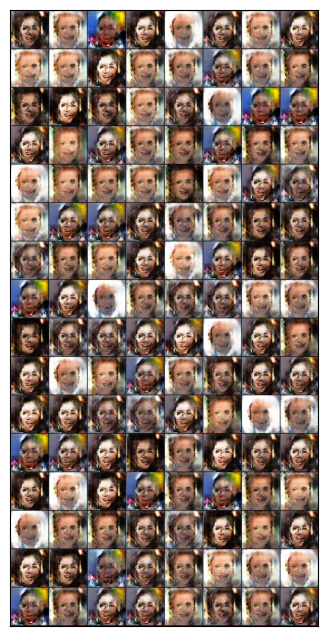

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

#ax.imshow(generated_img)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

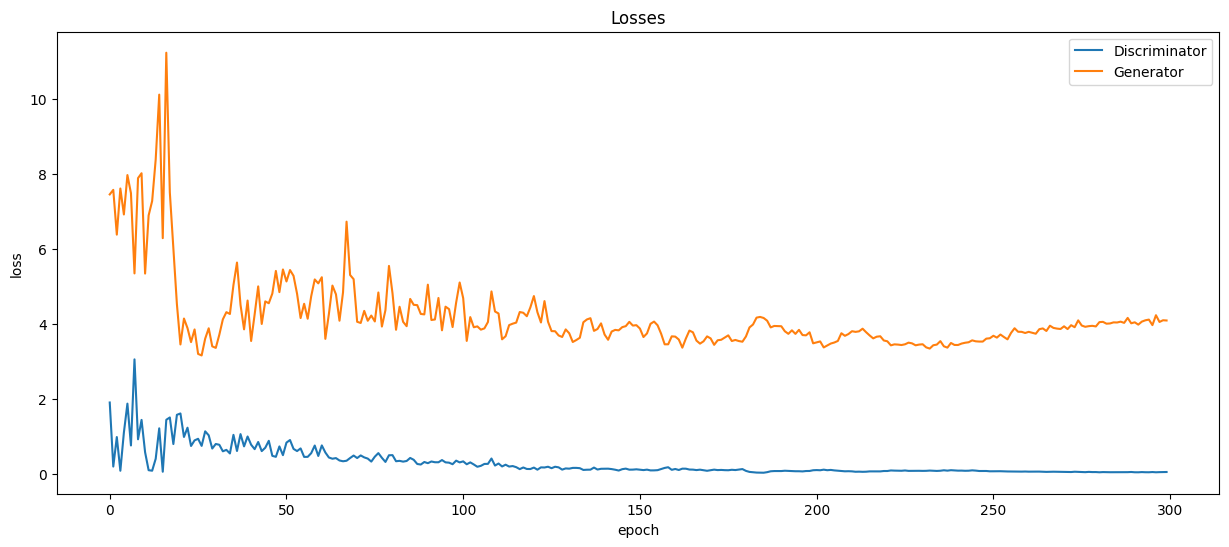

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

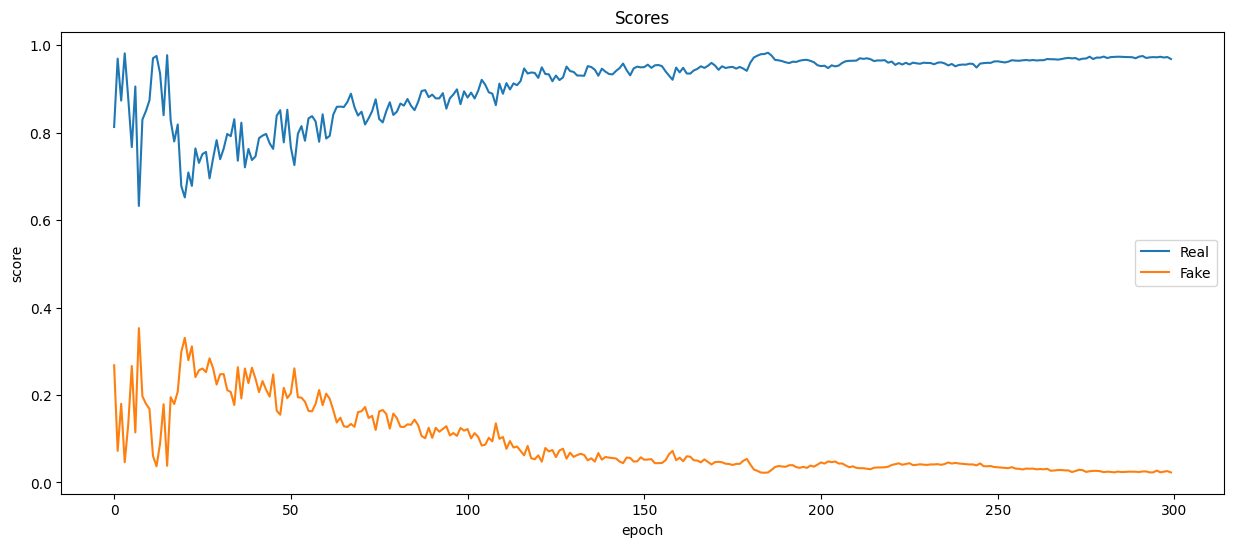

In [29]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [30]:
n_images = 16

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent).detach().cpu()
fake_images.shape

torch.Size([16, 3, 128, 128])

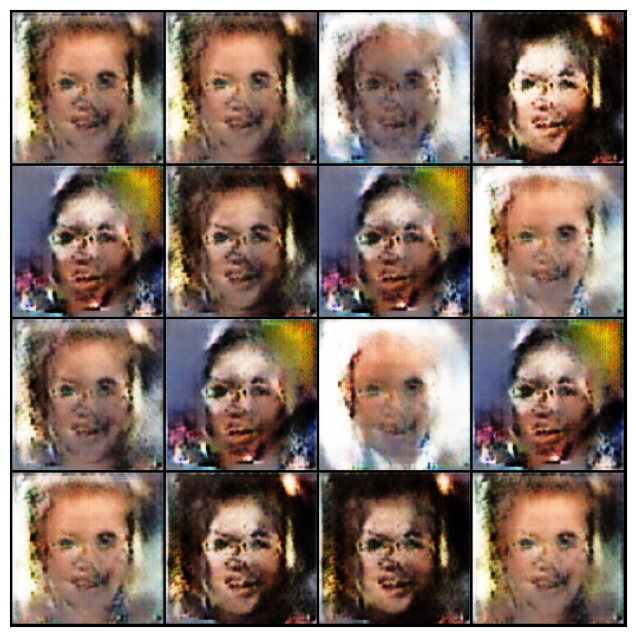

In [31]:
show_images(fake_images)

Как вам качество получившихся изображений?

Эеспрессивно

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [32]:
images, labels = [], []
batches = 10

with torch.no_grad():
    for _ in trange(batches):
        fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](fixed_latent).detach().cpu()
        images.append(fake_images.numpy().reshape(batch_size, -1))
        images.append(next(enumerate(train_dl))[1].detach().cpu().numpy().reshape(batch_size, -1))
        labels.append([0] * batch_size)
        labels.append([1] * batch_size)

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)
images.shape, labels.shape

  0%|          | 0/10 [00:00<?, ?it/s]

((2560, 49152), (2560,))

In [33]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [34]:
images, labels = unison_shuffled_copies(images, labels)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
knn = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [36]:
total, eq = 0, 0
for i, (train_index, test_index) in enumerate(loo.split(images, labels)):
    knn.fit(images[train_index], labels[train_index])
    eq += knn.predict(images[test_index])[0] == labels[test_index][0]
    total += 1
    if i > 200:
        break

accuracy = eq / total
accuracy

0.9300990099009901

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

В идеале тут accuracy = 0.5; это бы означало, что сгенерированные изображения не отличимы от настоящих; accuracy < 0.7 -- хотелось бы получить;

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [37]:
tsne = TSNE()
images = torch.Tensor(images)
embedded = tsne.fit_transform(images)

/tmp/ipykernel_27/2545923319.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<Axes: >

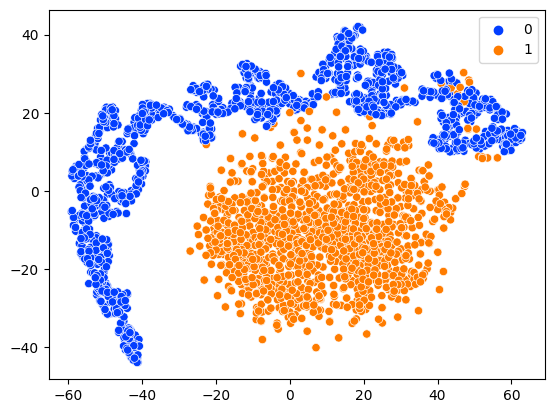

In [38]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(
    x=embedded[:,0], y=embedded[:, 1], hue=labels, legend='full', palette=palette
)

Прокомментируйте получившийся результат:

Тут два класса хорошо отличимы, что не есть хорошо; нужно дольше обучать / пробовать другие архитектуры; увеличить слои в текущей архитектуре;